# Project: Kernelization, Kernel Tricks

**Put any package imports you need in the below space**

In [48]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA, KernelPCA
from sklearn import svm as SVM
from sklearn.model_selection import train_test_split
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.kernel_approximation import RBFSampler

**Exercise 1: Generating the data sets.**

Write a script that generates three data sets in a 2-dimensional space, defined as follows:
1. BAD_kmeans: a data set for which the k-means clustering algorithm will not perform well.
2. BAD_pca: a data set for which the Principal Component Analysis (PCA) dimension reduction method upon projection of the original points onto 1-dimensional space (i.e., the first eigenvector) will not perform well.
3. BAD_svm: a data set for which the linear Support Vector Machine (SVM) supervised classification method using two classes of points (positive and negative)  will not perform well.
4. Plot each data set in a 2-dimensional space.
    
Note: If appropriate, the same data set may be used for multiple parts.

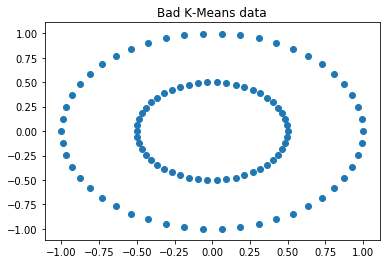

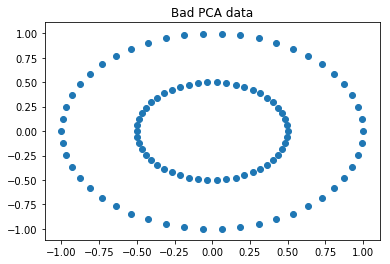

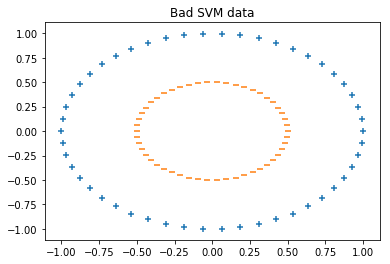

In [49]:
#Generate data set for which the k-means clustering algorithm will not perform well
BAD_kmeans,BAD_kmeansLabels = make_circles(n_samples=100, factor=0.5)
#Plot data for K-means
plt.scatter(BAD_kmeans[:,0], BAD_kmeans[:,1])
plt.title("Bad K-Means data")
plt.show()

#Generate data set for which PCA will not perform well
BAD_pca, BAD_pcaLabels = BAD_kmeans, BAD_kmeansLabels
#Plot data for PCA
plt.scatter(BAD_pca[:, 0], BAD_pca[:, 1])
plt.title("Bad PCA data")
plt.show()

#Generate data set for which SVM will not perform well
BAD_svm = BAD_kmeans
BAD_svmLabels = BAD_kmeansLabels
#Plot data for SVM
BAD_svmPositive= BAD_svm[BAD_svmLabels==0]
BAD_svmNegative = BAD_svm[BAD_svmLabels==1]
plt.scatter(BAD_svmPositive[:,0], BAD_svmPositive[:,1] , marker='+' )
plt.scatter(BAD_svmNegative[:,0], BAD_svmNegative[:,1] , marker='_')
plt.title("Bad SVM data")
plt.show()


**Exercise 2: Evaluating the "badness" of the data mining methods.**

Write a script that uses the BAD data sets in Exercise 1, runs the corresponding data mining method, produces the output of the method, and evaluates the performance of the method using (e.g., 10-fold) cross-validation and various performance metrics (e.g., variance, precision, recall, F1 measure). Note that not all metrics can be equally applied to every method. Report the performance metrics used and a summary of the results obtained. Reading the chapter “Performance Metrics for Graph Mining Tasks” by Kanchana Padmanabhan and John Jenkins in the resources for performance metrics is strongly encouraged for performing this exercise. 

In [55]:
def evaluateBadness(BAD_kmeans, BAD_pca, BAD_svm, svmKernel):
    kmeans = KMeans(n_clusters=2, random_state=0)
    BAD_kmeansOutput = kmeans.fit(BAD_kmeans)
    BAD_clusters = kmeans.predict(BAD_kmeans)
    CVSkmeans = np.mean(cross_val_score(kmeans, BAD_kmeans, BAD_kmeansLabels, cv=10))
    print("10-fold cross validation score for Kmeans: ",CVSkmeans)
    print("\nPerformance metrics for Kmeans\n")
    performanceKmeans = classification_report(BAD_kmeansLabels,BAD_clusters)
    print(performanceKmeans)
    print("-----------------------------------------------------------------")

    #Perform PCA
    pca = PCA(n_components=1)
    BAD_pcaOutput = pca.fit(BAD_pca)
    CVSpca = np.mean(cross_val_score(pca, BAD_pca, BAD_pcaLabels, cv=10))
    print("10-fold cross validation score for PCA: ",CVSpca)
    variancePCA = pca.explained_variance_ratio_[0]
    print("Variance for PCA: ",variancePCA)
    print("-----------------------------------------------------------------")

    #Generate test and training samples for SVM
    xTrainSVM, xTestSVM, yTrainSVM, yTestSVM = train_test_split(BAD_svm, BAD_svmLabels, test_size=0.35, random_state=0)
    svm = SVM.SVC(kernel=svmKernel).fit(xTrainSVM, yTrainSVM)
    BAD_svmOutput = svm.predict(xTestSVM)
    CVSsvm = svm.score(xTestSVM, yTestSVM)
    print('10-fold cross validation score for SVM: ',CVSsvm)
    #Performance metrics for SVM
    print('\nPerformance metrics for SVM\n')
    print(classification_report(yTestSVM, BAD_svmOutput))
    print("Number of support vectors: " ,svm.n_support_)
    print("-----------------------------------------------------------------")
    

evaluateBadness(BAD_kmeans, BAD_pca, BAD_svm, 'linear')

('10-fold cross validation score for Kmeans: ', -5.205546375398414)

Performance metrics for Kmeans

              precision    recall  f1-score   support

           0       0.50      0.50      0.50        50
           1       0.50      0.50      0.50        50

   micro avg       0.50      0.50      0.50       100
   macro avg       0.50      0.50      0.50       100
weighted avg       0.50      0.50      0.50       100

-----------------------------------------------------------------
('10-fold cross validation score for PCA: ', -1.713509845881075)
('Variance for PCA: ', 0.5000000000000002)
-----------------------------------------------------------------
('10-fold cross validation score for SVM: ', 0.37142857142857144)

Performance metrics for SVM

              precision    recall  f1-score   support

           0       0.37      1.00      0.54        13
           1       0.00      0.00      0.00        22

   micro avg       0.37      0.37      0.37        35
   macro avg      

**Exercise 3: Kernelizing the methods.**

Write a script that uses the kernelized version of each of the data mining methods in Exercise 2.
1. Choose at least two kernels for each method.
2. Use the same performance metrics as in Exercise 2 and compare the performance of the original un-kernelized version of the method versus the performance obtained after applying the kernel trick.
3. Do you observe a difference in performance when you use different kernels?
4. What are the best performance results you obtain by trying different kernels and kernel parameters? Also, make sure to report the number of support vectors for the SVM (a good rule of thumb is to strive for no more than 35%-50% support vectors to avoid model overfitting).

In [51]:
#Kernel 1: RBF
rbfKernelKmeans = pairwise_kernels(BAD_kmeans, metric="rbf")
rbfKernelPCA = pairwise_kernels(BAD_pca, metric="rbf")
rbfKernelSVM = rbfKernelKmeans

evaluateBadness(rbfKernelKmeans, rbfKernelPCA, rbfKernelSVM, 'rbf')

('10-fold cross validation score for Kmeans: ', -46.72320317584366)

Performance metrics for Kmeans

              precision    recall  f1-score   support

           0       0.50      0.50      0.50        50
           1       0.50      0.50      0.50        50

   micro avg       0.50      0.50      0.50       100
   macro avg       0.50      0.50      0.50       100
weighted avg       0.50      0.50      0.50       100

-----------------------------------------------------------------
('10-fold cross validation score for PCA: ', 16.04893718376792)
('Variance for PCA: ', 0.41670256666263217)
-----------------------------------------------------------------
('10-fold cross validation score for SVM: ', 1.0)

Performance metrics for SVM

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        22

   micro avg       1.00      1.00      1.00        35
   macro avg       1.00      1.00 

In [52]:
#Kernel 2: Polynomial
polyKernelKmeans = pairwise_kernels(BAD_kmeans, metric="poly")
polyKernelPCA = pairwise_kernels(BAD_pca, metric="poly")
polyKernelSVM = polyKernelKmeans

evaluateBadness(polyKernelKmeans, polyKernelPCA, polyKernelSVM, 'poly')

('10-fold cross validation score for Kmeans: ', -434.18625834757376)

Performance metrics for Kmeans

              precision    recall  f1-score   support

           0       0.50      0.50      0.50        50
           1       0.50      0.50      0.50        50

   micro avg       0.50      0.50      0.50       100
   macro avg       0.50      0.50      0.50       100
weighted avg       0.50      0.50      0.50       100

-----------------------------------------------------------------
('10-fold cross validation score for PCA: ', -94.32469102236014)
('Variance for PCA: ', 0.47015334069986897)
-----------------------------------------------------------------
('10-fold cross validation score for SVM: ', 1.0)

Performance metrics for SVM

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        22

   micro avg       1.00      1.00      1.00        35
   macro avg       1.00      1.0

**Exercise 4: Pipelining.**

Dimension reduction is often used as a key data pre-processing step for other data mining methods downstream the end-to-end data analysis. In this exercise, you will use unsupervised kernel PCA as a pre-processing step for clustering. Later in the course, we will use supervised dimension reduction methods as a pre-processing step for supervised classification methods.
1. Generalize your BAD_kmeans data set to very high-dimensional space (d>>2).
2. Show that the k-means clustering algorithm does not perform well on that data.
3. Apply the kernel PCA method to this high dimensional data set and identify the number (m<<d) of principal components (i.e., eigenvectors) that provide a reasonably good low-dimensional approximation of your data (i.e., based on eigenvalue distribution). How much total variability of the data will be preserved upon using this low-dimensional representation?
4. Project your original data onto the top m eigenvectors corresponding to the largest eigenvalues.
5. Run the k-means clustering algorithm on the projected low dimensional data.
6. Compare the performance of the k-means clustering algorithm on the d-dimensional original data vs. the m-dimensional projected data. Has the performance improved?
7. If you run the kernel k-means clustering algorithm on the original data, will you get better or worse performance? Discuss the pros and cons of using kernel k-means on the original data directly versus applying kernel PCA as a pre-processing step and then running the k-means clustering algorithm on the low-dimensional data.

In [53]:
rbfsampler = RBFSampler(n_components=100)
BAD_high = rbfsampler.fit_transform(BAD_kmeans)
BAD_highLabels = BAD_kmeansLabels

#Performing Kmeans on high-dimnesional data
kmeans = KMeans(n_clusters=2, random_state=0)
BAD_kmeansOutputHigh = kmeans.fit(BAD_high)
BAD_clustersHigh = kmeans.predict(BAD_high)
#10-fold cross validation score for high dimensional K-means
CVSkmeansHigh = np.mean(cross_val_score(kmeans, BAD_high, BAD_highLabels, cv=10))
print("10-fold cross validation score for Kmeans on High-dimnesional Data: ",CVSkmeansHigh)
#Performance metrics for high dimensional Kmeans
print("\nPerformance metrics for Kmeans on High-dimnesional Data\n")
performanceKmeansHigh = classification_report(BAD_highLabels,BAD_clustersHigh)
print(performanceKmeansHigh)
print("-----------------------------------------------------------------")


('10-fold cross validation score for Kmeans on High-dimnesional Data: ', -4.769986077513586)

Performance metrics for Kmeans on High-dimnesional Data

              precision    recall  f1-score   support

           0       0.48      0.52      0.50        50
           1       0.48      0.44      0.46        50

   micro avg       0.48      0.48      0.48       100
   macro avg       0.48      0.48      0.48       100
weighted avg       0.48      0.48      0.48       100

-----------------------------------------------------------------


('Variance for Kernelized PCA on high-dimensional data: ', 0.4926332872462706)
('Explained Variance ratio: ', 0.2651976169318841)


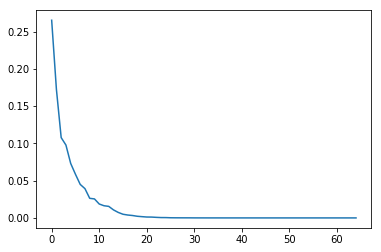

('Explained Variance ratio: ', array([0.30439148, 0.17519677]))
-----------------------------------------------------------------
('10-fold cross validation score for Kmeans on new data: ', -2.2714977337141757)
Performance metrics for Kernel PCA KMeans
              precision    recall  f1-score   support

           0       0.52      0.50      0.51        50
           1       0.52      0.54      0.53        50

   micro avg       0.52      0.52      0.52       100
   macro avg       0.52      0.52      0.52       100
weighted avg       0.52      0.52      0.52       100

-----------------------------------------------------------------


In [54]:
# Applying Kernelized PCA on high-dimensional data
rbfKernelHigh = pairwise_kernels(BAD_high, metric="rbf")
kernelpca = PCA()
pcaHigh = kernelpca.fit_transform(rbfKernelHigh)
variancePCAHigh = kernelpca.explained_variance_ratio_[0]
print("Variance for Kernelized PCA on high-dimensional data: ",variancePCAHigh)

#Generate test and training samples 
xTrain, xTest, yTrain, yTest = train_test_split(BAD_high, BAD_highLabels, test_size=0.35, random_state=0)
xTrain = rbfsampler.fit_transform(xTrain)
xTest = rbfsampler.fit_transform(xTest)


#Perform PCA
kernelpca = PCA()
pcaTrain = kernelpca.fit_transform(xTrain)
print("Explained Variance ratio: " ,kernelpca.explained_variance_ratio_[0])
plt.plot(kernelpca.explained_variance_ratio_)
plt.show()

kernelPCA2 = PCA(n_components=2)
pcaTrain2 = kernelPCA2.fit_transform(xTrain)
pcaTest2 = kernelPCA2.fit_transform(xTest)
print("Explained Variance ratio: " ,kernelPCA2.explained_variance_ratio_)
print("-----------------------------------------------------------------")

#Running Kmeans on new data
newData = kernelPCA2.fit_transform(BAD_high)
kmeans.fit(newData)
clusters2 = kmeans.predict(newData)
#10-fold cross validation score for K-means on projected data
CVSkmeans2 = np.mean(cross_val_score(kmeans, newData, BAD_highLabels, cv=10))
print("10-fold cross validation score for Kmeans on new data: ",CVSkmeans2)
#Performance metrics
print('Performance metrics for Kernel PCA KMeans')
print(classification_report(BAD_highLabels, clusters2))
print("-----------------------------------------------------------------")